# Installing Libraries


In [1]:
!pip install -qU gcvit --no-deps
!pip install -q tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 1.2 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

import os
import sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# TPU/GPU Detection

In [3]:
try:  # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()  # TPU detection
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:  # detect GPUss
    strategy = (
        tf.distribute.get_strategy()
    )  # default strategy that works on CPU and single GPU
print("Number of Accelerators: ", strategy.num_replicas_in_sync)

Number of Accelerators:  8


# Configuration for the flower dataset

In [4]:
# Model
IMAGE_SIZE = [224, 224]

# TPU
if tpu:
    BATCH_SIZE = (
        16 * strategy.num_replicas_in_sync
    )  # a TPU has 8 cores so this will be 128
else:
    BATCH_SIZE = 32  # on Colab/GPU, a higher batch size may throw(OOM)

# Dataset
CLASSES = [
    "dandelion",
    "daisy",
    "tulips",
    "sunflowers",
    "roses",
]  # don't change the order

# ImageNet dataset mean and standard deviation values for normalization.
MEAN = tf.constant([0.485 * 255, 0.456 * 255, 0.406 * 255])  # imagenet mean
STD = tf.constant([0.229 * 255, 0.224 * 255, 0.225 * 255])  # imagenet std

# A TensorFlow constant for dataset optimization.
AUTO = tf.data.AUTOTUNE

# Pipeline

In [5]:
def make_dataset(dataset: tf.data.Dataset, train: bool, image_size: int = IMAGE_SIZE):
    """
    Prepares a TensorFlow dataset for training or evaluation.

    Parameters:
    - dataset: A `tf.data.Dataset` object containing the data.
    - train: A boolean indicating if the dataset is for training. Controls whether data augmentation is applied.
    - image_size: The target size for image resizing as a list or tuple of two integers.

    Returns:
    A TensorFlow dataset processed and ready for model training or evaluation.
    """

    # Defines a preprocessing function to apply to each image and its label.
    def preprocess(image, label):
        # Apply data augmentation only if preparing the dataset for training.
        if train:
            # Randomly flip the image left to right with a 50% chance.
            if tf.random.uniform(shape=[]) > 0.5:
                image = tf.image.flip_left_right(image)

        # Resize the image to the specified size using bicubic interpolation for better quality.
        image = tf.image.resize(image, size=image_size, method="bicubic")

        # Normalize the image by subtracting the mean and dividing by the standard deviation.
        # This standardization is based on ImageNet statistics.
        image = (image - MEAN) / STD
        return image, label

    # If preparing the dataset for training, shuffle the data with a buffer size of 10 times the batch size.
    if train:
        dataset = dataset.shuffle(BATCH_SIZE * 10)

    # Map the preprocessing function to each element in the dataset, apply batching,
    # and enable prefetching to improve performance.
    return dataset.map(preprocess, AUTO).batch(BATCH_SIZE, drop_remainder=True).prefetch(AUTO)


# Flower Dataset

In [6]:
# Load the "tf_flowers" dataset from TensorFlow Datasets (TFDS). This dataset is split into training and validation sets.
# The first 90% of the data is used for training, and the last 10% is used for validation.
train_dataset, val_dataset = tfds.load(
    "tf_flowers",  # The dataset identifier in TensorFlow Datasets.
    split=["train[:90%]", "train[90%:]"],  # Splits the dataset into 90% training and 10% validation.
    as_supervised=True,  # Loads the dataset in a supervised format (i.e., with labels).
    try_gcs=True,  # Tries to load the dataset from Google Cloud Storage, which is beneficial when using TPUs.
)

# Calculate the number of examples in the training dataset.
num_train = tf.data.experimental.cardinality(train_dataset)
# Calculate the number of examples in the validation dataset.
num_val = tf.data.experimental.cardinality(val_dataset)

# Print the number of examples in the training and validation datasets.
print(f"Number of training examples: {num_train}")
print(f"Number of validation examples: {num_val}")


Number of training examples: 3303
Number of validation examples: 367


# Preparing the Dataset

In [7]:
train_dataset = make_dataset(train_dataset, True)
val_dataset = make_dataset(val_dataset, False)

In [8]:
# Fetch a batch of images and labels from the training dataset.
sample_images, sample_labels = next(iter(train_dataset))

# Set up a matplotlib figure with a specific size to display the images.
plt.figure(figsize=(5 * 3, 3 * 3))
for n in range(15):
    # For each of the first 15 images in the batch:
    ax = plt.subplot(3, 5, n + 1)  # Create a subplot for each image.

    # Undo the normalization to convert the images back to their original value range for visualization.
    image = (sample_images[n] * STD + MEAN).numpy()

    # Scale the image values to a [0, 1] range to ensure they display correctly with matplotlib,
    # which expects values in this range for RGB images.
    image = (image - image.min()) / (image.max() - image.min())

    plt.imshow(image)  # Display the image.
    plt.title(CLASSES[sample_labels[n]])  # Set the title of each subplot to the corresponding class name.
    plt.axis("off")  # Hide the axes for a cleaner look.

plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.show()  # Display the figure with the batch of images.


Output hidden; open in https://colab.research.google.com to view.

# LR Scheduler

In [9]:
# Define a custom learning rate schedule class that inherits from tf.keras.optimizers.schedules.LearningRateSchedule.
class WarmUpCosine(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()

        # Initialize the class with the base learning rate, total steps for the training,
        # the initial learning rate for the warmup, and the number of warmup steps.
        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)  # Define Pi as a constant value for later calculations.

    def __call__(self, step):
        # Custom call method that calculates the learning rate based on the current step.
        if self.total_steps < self.warmup_steps:
            # Ensure total_steps is larger than or equal to warmup_steps.
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")

        # Calculate the cosine learning rate adjusted based on the current step.
        learning_rate = (
            0.5
            * self.learning_rate_base
            * (
                1
                + tf.cos(
                    self.pi
                    * (tf.cast(step, tf.float32) - self.warmup_steps)
                    / float(self.total_steps - self.warmup_steps)
                )
            )
        )

        if self.warmup_steps > 0:
            # Check if there is a warmup phase.
            if self.learning_rate_base < self.warmup_learning_rate:
                # Ensure the base learning rate is not less than the warmup learning rate.
                raise ValueError(
                    "Learning_rate_base must be larger or equal to warmup_learning_rate."
                )
            # Calculate the linear increase in learning rate during the warmup phase.
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            # Apply the warmup learning rate for steps within the warmup phase, otherwise use the cosine decay rate.
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        # Ensure the learning rate drops to 0 after exceeding total_steps.
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )


# Define Hyperparameters

In [10]:
# Set the total number of epochs the model will be trained for.
EPOCHS = 10

# Specify the number of initial steps during which the learning rate will be increased as part of a warmup strategy.
WARMUP_STEPS = 10

# Define the initial learning rate that will be used at the start of training (after the warmup phase).
INIT_LR = 0.03

# Set the learning rate for the warmup period, which is lower than the initial learning rate.
WAMRUP_LR = 0.006  # Note: It should probably be WARMUP_LR.

# Calculate the total number of steps the training will run.
# This is based on how many batches of data fit into one epoch (total number of training examples divided by batch size)
# and then multiplied by the number of epochs to get the overall number of steps across all epochs.
TOTAL_STEPS = int((num_train / BATCH_SIZE) * EPOCHS)


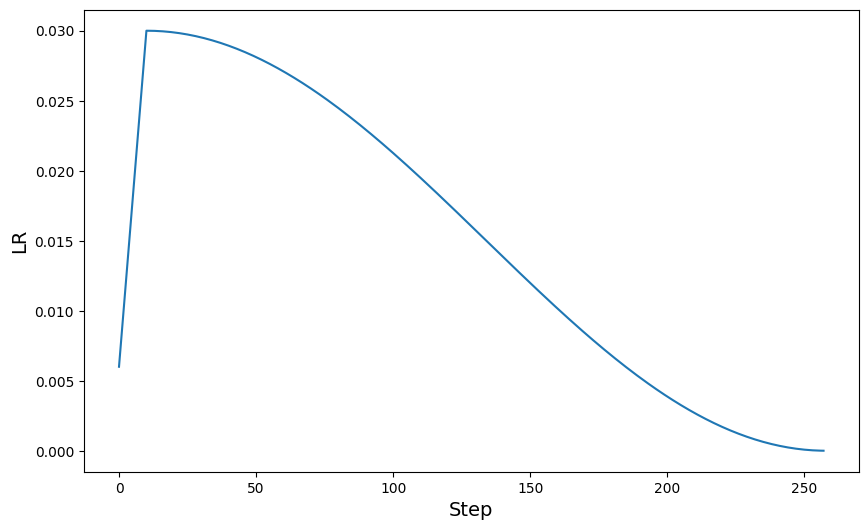

In [11]:
scheduled_lrs = WarmUpCosine(
    learning_rate_base=INIT_LR,
    total_steps=TOTAL_STEPS,
    warmup_learning_rate=WAMRUP_LR,
    warmup_steps=WARMUP_STEPS,
)

lrs = [scheduled_lrs(step) for step in range(TOTAL_STEPS)]
plt.figure(figsize=(10, 6))
plt.plot(lrs)
plt.xlabel("Step", fontsize=14)
plt.ylabel("LR", fontsize=14)
plt.show()

In [12]:
# Initialize the optimizer for the model's training process.
# Here, a Stochastic Gradient Descent (SGD) optimizer is used, with a learning rate schedule passed as its learning rate parameter.
# The 'scheduled_lrs' should be an instance of a learning rate schedule, such as the WarmUpCosine schedule previously defined.
# This schedule dynamically adjusts the learning rate during training, which can help improve model performance and convergence.
optimizer = keras.optimizers.SGD(scheduled_lrs)

# Define the loss function for the model. The Sparse Categorical Crossentropy loss is used, which is suitable for multi-class classification problems
# where the labels are integers (as opposed to one-hot encoded vectors).
# This loss function compares the predicted probability distribution over the classes with the true distribution, where the true class label
# is represented as an integer. It measures the discrepancy between these distributions and aims to minimize it during training.
loss = keras.losses.SparseCategoricalCrossentropy()


**Download GCViT Algorithm**

In [13]:
pip install gcvit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━

In [14]:
from gcvit import GCViTTiny

with strategy.scope():
    model = GCViTTiny(input_shape=(*IMAGE_SIZE,3), pretrain=True)
    model.reset_classifier(num_classes=104, head_act='softmax')

model.compile(loss=loss,
              optimizer=optimizer,
              metrics=["accuracy"])

113498376/113498376 [==============================] - 1s 0us/step


# Saving Checkpoint

In [15]:
ckpt_path = 'model.h5'
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=ckpt_path,
    save_best_only=True,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1)

# Training

In [16]:
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=EPOCHS,
                    callbacks=[ckpt_callback])

Epoch 1/10
25/25 [==============================] - ETA: 0s - loss: 2.3879 - accuracy: 0.4172
Epoch 1: val_accuracy improved from -inf to 0.75391, saving model to model.h5
25/25 [==============================] - 169s 2s/step - loss: 2.3879 - accuracy: 0.4172 - val_loss: 0.6954 - val_accuracy: 0.7539
Epoch 2/10
25/25 [==============================] - ETA: 0s - loss: 0.5697 - accuracy: 0.8153
Epoch 2: val_accuracy improved from 0.75391 to 0.85156, saving model to model.h5
25/25 [==============================] - 10s 412ms/step - loss: 0.5697 - accuracy: 0.8153 - val_loss: 0.4014 - val_accuracy: 0.8516
Epoch 3/10
25/25 [==============================] - ETA: 0s - loss: 0.3653 - accuracy: 0.8822
Epoch 3: val_accuracy improved from 0.85156 to 0.88281, saving model to model.h5
25/25 [==============================] - 10s 408ms/step - loss: 0.3653 - accuracy: 0.8822 - val_loss: 0.2853 - val_accuracy: 0.8828
Epoch 4/10
25/25 [==============================] - ETA: 0s - loss: 0.2950 - accurac

# Training History

<Axes: xlabel='epoch', ylabel='score'>

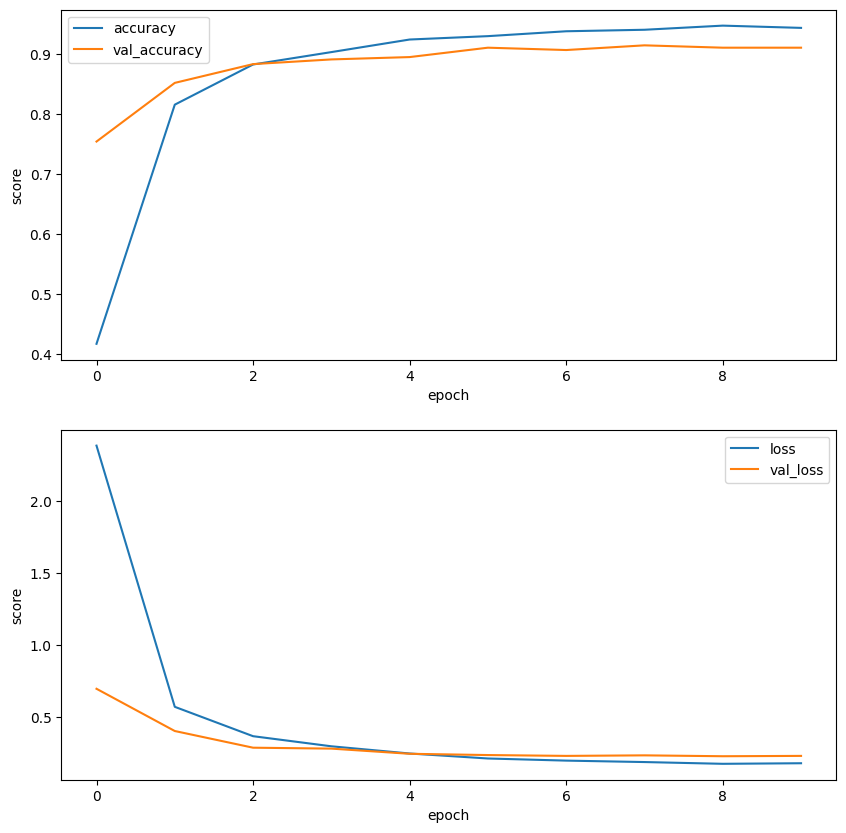

In [17]:
result = pd.DataFrame(history.history)
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
result[["accuracy", "val_accuracy"]].plot(xlabel="epoch", ylabel="score", ax=ax[0])
result[["loss", "val_loss"]].plot(xlabel="epoch", ylabel="score", ax=ax[1])


# Visualize

In [21]:
plt.figure(figsize=(5 * 4, 3 * 4))
for i in range(15):
    ax = plt.subplot(3, 5, i + 1)
    image = (sample_images[i] * STD + MEAN).numpy()
    image = (image - image.min()) / (
        image.max() - image.min()
    )  # convert to [0, 1] for avoiding matplotlib warning
    plt.imshow(image)
    target = CLASSES[sample_labels[i]]
    pred = CLASSES[predictions[i]]
    plt.title("label: {} | pred: {}".format(target, pred), fontsize=12)
    plt.axis("off")
plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

# Grad-Cam

In [23]:
from gcvit.utils import get_gradcam_model, get_gradcam_prediction
from tqdm import tqdm

In [24]:
gradcam_model = get_gradcam_model(model) # make gradcam model

In [25]:
# Generate Grad-CAM heatmaps
heatmaps = []
for i in tqdm(range(15)):
  pred, heatmap = get_gradcam_prediction(sample_images[i].numpy(), gradcam_model, process=False, decode=False)
  heatmaps.append(heatmap)

100%|██████████| 15/15 [02:08<00:00,  8.56s/it]


In [26]:
plt.figure(figsize=(5 * 4, 3 * 4))
for i in range(15):
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(heatmaps[i])
    target = CLASSES[sample_labels[i]]
    pred = CLASSES[predictions[i]]
    plt.title("label: {} | pred: {}".format(target, pred), fontsize=12)
    plt.axis("off")
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.